# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [16]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [17]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [29]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Worst aircraft I have ever ...
1,✅ Trip Verified | I enjoyed my flight. The bo...
2,✅ Trip Verified | Why do you make it so hard? ...
3,✅ Trip Verified | After several delays and ca...
4,Not Verified | Literally the worst flight of ...


In [34]:
df.to_csv("data/BA_reviews.csv")

,reviews
0,| Worst aircraft I have ever flown. The sea...
1,| I enjoyed my flight. The boarding was swi...
2,| Why do you make it so hard? After a so so ...
3,| After several delays and canceled flights...
4,Not Verified | Literally the worst flight of ...
...,...
995,"| Earlier this year, my wife and I travelle..."
996,Not Verified | Los Angeles to London. I booke...
997,Not Verified | The overall flight wasn't too ...
998,| \r\nBA’s Galleries lounge at CPT is adequa...


Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [35]:
import emoji
#data cleaning
df.dropna()
#remove emojis
df = pd.DataFrame(df.reviews.apply(lambda s: emoji.replace_emoji(s, '')))
#remove not verified trip comments
df = df[~df['reviews'].str.contains('Not Verified')]
#remove unnecessary words
df = pd.DataFrame(df.reviews.apply(lambda s: s.replace('Trip Verified', '')))


,reviews
0,| Worst aircraft I have ever flown. The sea...
1,| I enjoyed my flight. The boarding was swi...
2,| Why do you make it so hard? After a so so ...
3,| After several delays and canceled flights...
5,| I swore I would never fly BA again after ...
...,...
993,| Glasgow to New York JFK via London. Outgo...
994,| Flew on a last minute emergency trip Lond...
995,"| Earlier this year, my wife and I travelle..."
998,| \r\nBA’s Galleries lounge at CPT is adequa...


In [37]:
#sentiment analysis
from textblob import TextBlob
df['polarity'] = df['reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [40]:
import numpy as np
# give a sentiment score to each review
conditions = [
    (df['polarity'] > 0),
    (df['polarity'] < 0),
    (df['polarity'] == 0)
]
choices = ['positive', 'negative', 'neutral']
df['sentiment'] = np.select(conditions, choices)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/caokepan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/caokepan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/caokepan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/caokepan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


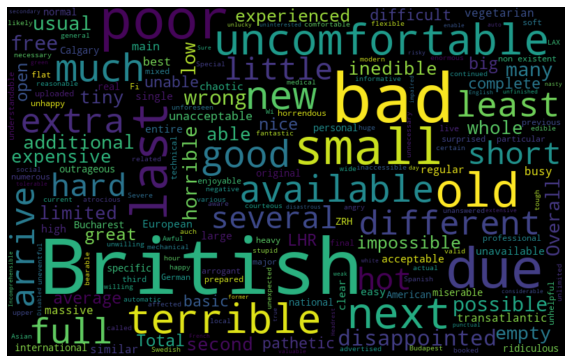

In [64]:
# create negative word cloud
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
import matplotlib.pyplot as plt

stop_words = set(stopwords.words('english'))

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

negative_reviews = df[df['sentiment'] == 'negative']['reviews']
all_negative_reviews = ' '.join(negative_reviews)
all_negative_reviews = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(all_negative_reviews) if not w in stop_words and pos_tag([w])[0][1] in ['JJ', 'JJR', 'JJS']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, stopwords=stop_words).generate(all_negative_reviews)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

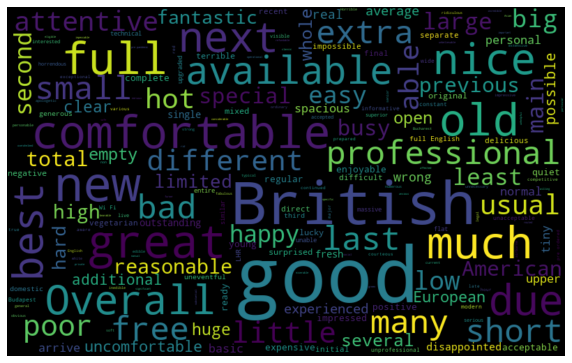

In [65]:
# create positive word cloud
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

from wordcloud import WordCloud
import matplotlib.pyplot as plt

stop_words = set(stopwords.words('english'))

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

positive_reviews = df[df['sentiment'] == 'positive']['reviews']
all_positive_reviews = ' '.join(positive_reviews)
all_positive_reviews = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(all_positive_reviews) if not w in stop_words and pos_tag([w])[0][1] in ['JJ', 'JJR', 'JJS']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, stopwords=stop_words).generate(all_positive_reviews)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

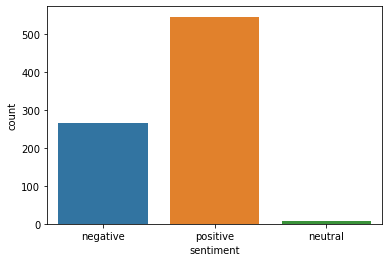

In [45]:
#plot sentiment distribution
import seaborn as sns
sns.countplot(x='sentiment', data=df)
plt.show()

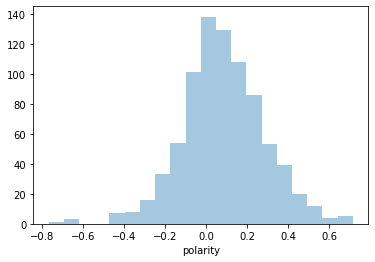

In [81]:
#plot the polarity distribution without reviews shown on the y-axis and create a histogram and line graph
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(df['polarity'], kde=False, bins=20)
plt.show()

In [89]:
!git remote add origin https://github.com/invisiblecao/BritishAirwaysDSProject.git
!git branch -M main
!git push -u origin main

Username for 'https://github.com': ^C
